In [113]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

In [114]:
def formatPrice(n):
    return ("-" if n < 0 else "") + "{0:.2f}".format(abs(n))

In [115]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [116]:
class Deep_Evolution_Strategy:

    def __init__( self, weights, reward_function, save_model, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.save_model = save_model
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch, print_every):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            
            for k in range(self.population_size):
                x = []
                
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            
            for index in range(self.population_size):
                weights_population = self.get_weight_from_population(self.weights, population[index])
                rewards[k] = self.reward_function(weights_population)
            
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)
            
            reward = self.reward_function(self.weights)
            
            if (i + 1) % print_every == 0:
                print('episode %d. reward: %f' % (i + 1, reward))
    
            self.save_model()
        print('Total time:', time.time() - lasttime, 'seconds')

In [117]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights
    
    def save_model(self):
        weights = self.get_weights()
        np.save('models/model', weights)
    
    def load_model(file):
        weights = np.load('models/model.npy')
        return weights

In [118]:
class Agent:

    population_size = 33
    sigma = 0.36
    learning_rate = 0.48

    def __init__(self, model, close, capital):
        self.model = model
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.model.save_model,
            self.population_size,
            self.sigma,
            self.learning_rate,
        )
        self.close = close
        self.start_capital = capital

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_reward(self, weights):
        capital = self.start_capital 
        l = len(self.close) - 1
        self.model.set_weights(weights)
        window_size = 37
        state = get_state(self.close, 0, window_size + 1)
        inventory = []
        
        for t in range(0, l):
            action = self.act(state)
            
            #hold
            next_state = get_state(self.close, t + 1, window_size + 1)
            
            #buy
            if action == 1 and capital >= self.close[t]:
                inventory.append(self.close[t])
                capital -= self.close[t]
            
            #sell
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                capital += self.close[t]

            state = next_state
        
        return ((capital - self.start_capital)/self.start_capital)*100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, checkpoint)

    def simulate(self, test, start_capital):
        capital = start_capital
        window_size = 37
        state = get_state(test, 0, window_size + 1)
        states_sell = []
        states_buy = []
        inventory = []
        total_profit = 0
        l = len(test) - 1
        
        for t in range(0, l):
            action = self.act(state)
            
            #hold
            next_state = get_state(test, t + 1, window_size + 1)
            
            #buy
            if action == 1 and capital >= test[t]:
                capital -= test[t]
                inventory.append(test[t])
                total_profit -= test[t]
                states_buy.append(t)
                print ("Buy: " + formatPrice(test[t]))
            
            #sell
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                capital += test[t]
                total_profit += test[t]
                states_sell.append(t)
                print ("Sell: " + formatPrice(test[t]) + " | Profit: " + formatPrice(test[t] - bought_price))
            
            state = next_state

        print('\nTotal %f' % (total_profit))
        plt.figure(figsize = (40, 20))
        plt.plot(test, label = 'true close', c = 'g')
        plt.plot(
            test, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            test, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [119]:
window_size = 37
test = pd.read_csv('dataset/Vale(test).csv')
test = test[::-1]
data = pd.read_csv('dataset/Vale.csv')
data = data[::-1]
close = data.Fechamento.values.tolist()
test = test.Fechamento.values.tolist()

In [120]:
model = Model(window_size, 602, 3)
agent = Agent(model, close, 50)
agent.fit(1000, 10)

episode 10. reward: -24.180000
episode 20. reward: -10.020000
episode 30. reward: 94.480000
episode 40. reward: 0.680000
episode 50. reward: 20.300000
episode 60. reward: 106.300000
episode 70. reward: 26.100000
episode 80. reward: 49.360000
episode 90. reward: 115.040000
episode 100. reward: 15.200000
episode 110. reward: 27.020000
episode 120. reward: 17.960000
episode 130. reward: 13.720000
episode 140. reward: 96.920000
episode 150. reward: 39.300000
episode 160. reward: 76.680000
episode 170. reward: 29.260000
episode 180. reward: 135.260000
episode 190. reward: 172.100000
episode 200. reward: 118.600000
episode 210. reward: 126.280000
episode 220. reward: 90.320000
episode 230. reward: 33.500000
episode 240. reward: 78.540000
episode 250. reward: 77.440000
episode 260. reward: 77.120000
episode 270. reward: 70.640000
episode 280. reward: 31.080000
episode 290. reward: 54.700000
episode 300. reward: 82.800000
episode 310. reward: 49.820000
episode 320. reward: 20.800000
episode 33

Buy: 52.60
Sell: 52.35 | Profit: -0.25
Buy: 55.08
Sell: 55.65 | Profit: 0.57
Buy: 44.68
Sell: 44.64 | Profit: -0.04
Buy: 44.30
Buy: 45.88
Sell: 45.25 | Profit: 0.95
Sell: 45.80 | Profit: -0.08
Buy: 48.05
Sell: 49.88 | Profit: 1.83
Buy: 50.46
Sell: 51.90 | Profit: 1.44
Buy: 50.05
Buy: 49.55
Buy: 50.28
Buy: 49.60
Sell: 49.30 | Profit: -0.75
Sell: 50.93 | Profit: 1.38
Sell: 51.63 | Profit: 1.35
Buy: 51.78
Buy: 52.16
Sell: 51.98 | Profit: 2.38
Sell: 52.35 | Profit: 0.57
Sell: 51.76 | Profit: -0.40
Buy: 53.10
Sell: 52.25 | Profit: -0.85
Buy: 50.33
Sell: 50.42 | Profit: 0.09

Total 8.190000


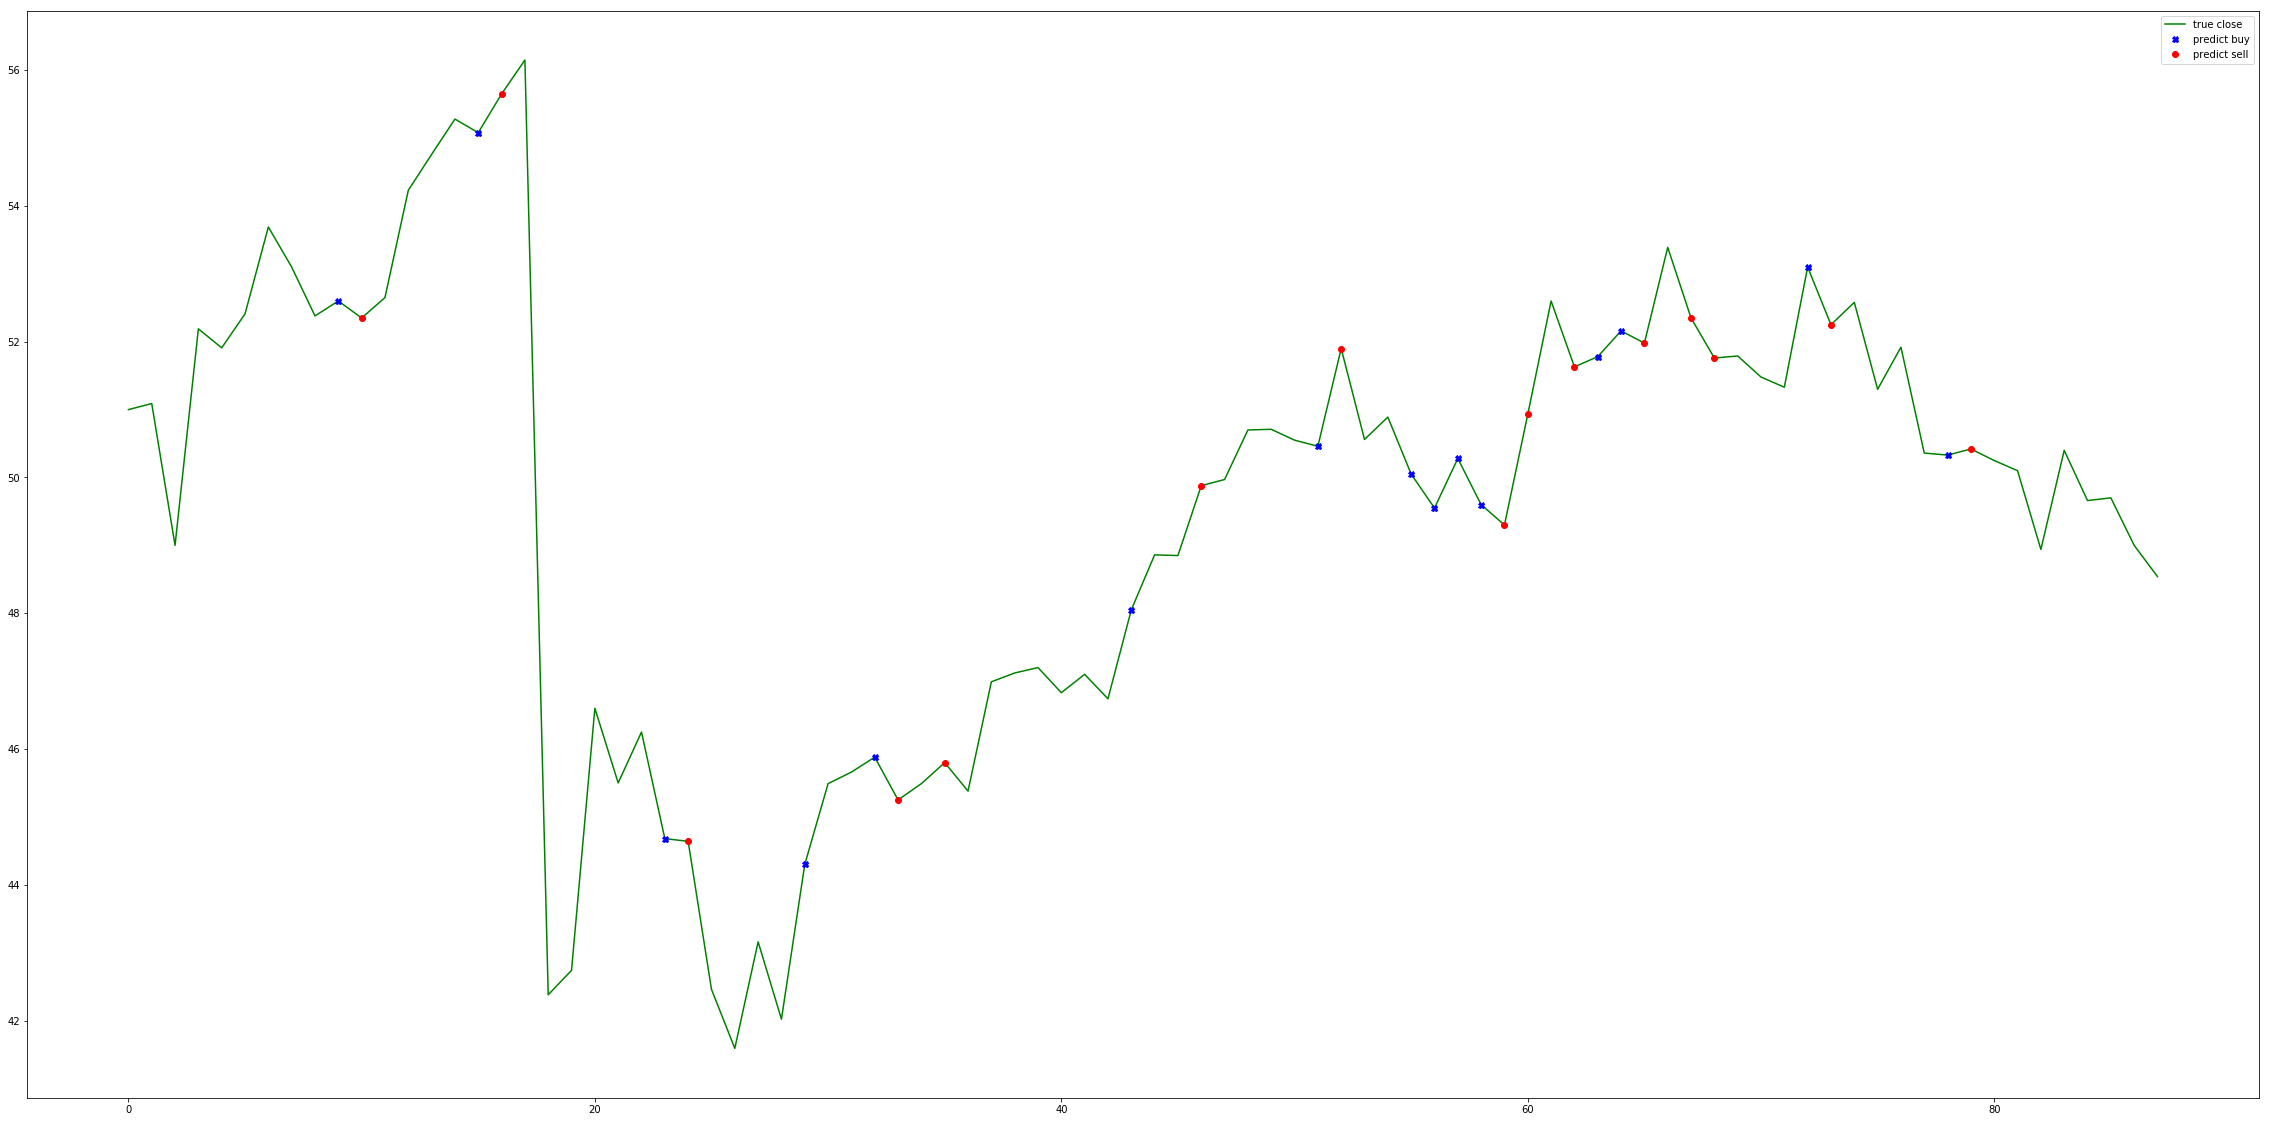

In [128]:
agent.simulate(test, 10000)